In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 48.2 ms (started: 2023-04-27 01:28:07 -04:00)


In [2]:
# %reload_ext dotenv

# %dotenv ../../env/.env

# import warnings
# import utils
# from pandas import Timedelta
# import time
# from utils import logger, sql_to_df, run_sql, session, conn
# import pandas as pd
# warnings.filterwarnings('ignore')

# try:
#     %load_ext autotime
# except:
#     !pip install ipython-autotime
#     %load_ext autotime

01:28:49 INFO:Snowflake Connector for Python Version: 2.7.12, Python Version: 3.8.16, Platform: macOS-10.15.7-x86_64-i386-64bit
01:28:49 INFO:This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
01:28:49 INFO:Setting use_openssl_only mode to False
01:28:50 INFO:Snowflake Connector for Python Version: 2.7.12, Python Version: 3.8.16, Platform: macOS-10.15.7-x86_64-i386-64bit
01:28:50 INFO:This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
01:28:51 INFO:Snowpark Session information: 
"version" : 1.3.0,
"python.version" : 3.8.16,
"python.connector.version" : 2.7.12,
"python.connector.session.id" : 876302180401158,
"os.name

connected to account omwykhw-jx58967 wh OPS db SNOWFLAKE_USAGE schema SANDBOX with role DEV
time: 17.9 ms (started: 2023-04-25 01:28:51 -04:00)


In [12]:
import logging
logger.setLevel(logging.INFO)

time: 5.63 ms (started: 2023-04-27 01:28:13 -04:00)


In [27]:
# # warehouse_ids = [41,42,43]
# warehouse_ids = [38,39,40]
# joined = ','.join([str(w) for w in warehouse_ids])
# sql_str = f"({joined})"

# sql = f"""
# select 
#     warehouse_id, 
#     era_start, 
#     era_end
# from query_era_test

# -- where warehouse_id in {sql_str}
# order by era_start asc
# """

# df = sql_to_df(sql)
# display(df)

09:44:43 INFO:query: [select warehouse_id, era_start, era_end from query_era_test  -- where warehouse_...]


using arrow to fetch results...


09:44:44 INFO:query execution done


,warehouse_id,era_start,era_end
0,35,2023-04-10 16:44:00,2023-04-10 16:44:10
1,35,2023-04-10 16:44:15,2023-04-10 16:44:25
2,35,2023-04-10 16:44:55,2023-04-10 16:45:05
3,35,2023-04-10 16:45:15,2023-04-10 16:45:25


time: 655 ms (started: 2023-04-20 21:44:43 -04:00)


In [5]:
for warehouse_id in df.warehouse_id.unique():
    print(warehouse_id)
    wh_df = df[df.warehouse_id == warehouse_id].sort_values('era_start', ascending=True)

35
time: 4.7 ms (started: 2023-04-20 21:31:30 -04:00)


In [31]:
pd.timedelta_range(wh_df.era_start.min(), wh_df.era_end.max(), freq="1min")


ValueError: Value must be Timedelta, string, integer, float, timedelta or convertible, not Timestamp

time: 53 ms (started: 2023-04-20 21:48:53 -04:00)


In [13]:
from pandas import Timestamp
query_eras = \
[(Timestamp('2023-04-10 16:44:00'), Timestamp('2023-04-10 16:44:10')),
 (Timestamp('2023-04-10 16:44:15'), Timestamp('2023-04-10 16:44:25')),
 (Timestamp('2023-04-10 16:44:55'), Timestamp('2023-04-10 16:45:05')),
 (Timestamp('2023-04-10 16:45:15'), Timestamp('2023-04-10 16:45:25'))]

qdf = pd.DataFrame(query_eras, columns=['era_start', 'era_end'])
qdf

,era_start,era_end
0,2023-04-10 16:44:00,2023-04-10 16:44:10
1,2023-04-10 16:44:15,2023-04-10 16:44:25
2,2023-04-10 16:44:55,2023-04-10 16:45:05
3,2023-04-10 16:45:15,2023-04-10 16:45:25


time: 103 ms (started: 2023-04-27 01:28:16 -04:00)


In [8]:
# %pip install duckdb

Note: you may need to restart the kernel to use updated packages.
time: 2.28 s (started: 2023-04-24 11:20:37 -04:00)


In [18]:
import snowflake.snowpark.functions as F
import snowflake.snowpark.dataframe

polling_sec = 1
# where warehouse_id in (
#     select warehouse_id from (
#         select top 10
#             warehouse_id,
#             warehouse_name,
#             sum(dollars_used)
#         from warehouse_metering_history_enriched
#         group by 1,2 order by 3 desc
#     )


def greedy_suspend(query_eras, autosuspend_sec):
    started = False
    resumed_on = None
    previous_end = None
    dt = Timedelta(seconds=autosuspend_sec)
    events = []
    for (start, end) in query_eras:
        # first process events between previous_end and start
        # suspend happens at: 
        # previous_end + 2*polling_period, as long as we're after resumed_on + 60 + 2*polling_period, 
        if started:
            timediff = start - previous_end 
            if timediff > dt:
                suspend_time = previous_end + dt
                started = False
                events.append((suspend_time, 'suspend'))

        if not started:
            started = True
            resumed_on = start
            events.append((resumed_on, 'resume'))

        previous_end = end
    
    if started:
        suspend_time = previous_end + dt
        started = False
        events.append((suspend_time, 'suspend')) 
        
    events_df = pd.DataFrame(events, columns=['timestamp', 'event_type'])
    return events_df

def snowflake_suspend(query_eras, autosuspend_sec):
#     dt = Timedelta(seconds=autosuspend_sec)
#     sixty = Timedelta(seconds=60)
    return greedy_suspend(query_eras, max(autosuspend_sec, 30))

def smart_suspend(query_eras, polling_sec):
    started = False
    running = 0
    resumed_on = None

    previous_end = None
    resumed_plus_sixty = None
    events = []
    for (start, end) in query_eras:
        
        # first process events between previous_end and start
        # suspend happens at: 
        # previous_end + 2*polling_period, as long as we're after resumed_on + 60 + 2*polling_period, 

        if started:
            first_check_after_previous_end = previous_end + 1*Timedelta(seconds=polling_sec)
            earliest_possible_suspend = max(first_check_after_previous_end, resumed_plus_sixty)
            if earliest_possible_suspend < start:
                started = False
                events.append((earliest_possible_suspend, 'suspend'))

        if not started:
            started = True
            resumed_on = start
            resumed_plus_sixty = resumed_on + Timedelta(seconds=60)
            events.append((resumed_on, 'resume'))

        previous_end = end
    
    if started:
        first_check_after_previous_end = previous_end + 1*Timedelta(seconds=polling_sec)
        earliest_possible_suspend = max(first_check_after_previous_end, resumed_plus_sixty)
        events.append((earliest_possible_suspend, 'suspend'))


    events_df = pd.DataFrame(events, columns=['timestamp', 'event_type'])
    return events_df

def wh_events_sim(df):
    warehouse_event_dfs = []
    for warehouse_id in df.warehouse_id.unique():
        print(warehouse_id)
        wh_df = df[df.warehouse_id == warehouse_id].sort_values('era_start', ascending=True)

        eras = list(zip(wh_df.era_start, wh_df.era_end))

        strategy = {'type': 'greedy_after_one_min', 'polling_sec': polling_sec}

        events_df = smart_suspend(eras, polling_sec)
        events_df['strategy'] = str(strategy)
        events_df['warehouse_id'] = warehouse_id
        warehouse_event_dfs.append(events_df)

        # autosuspend_sec = 60
        for autosuspend_sec in [30, 60, 120]:

            strategy = {'type': 'greedy', 'autosuspend_sec': autosuspend_sec}
            # print(strategy)
            events_df = greedy_suspend(eras, autosuspend_sec)
            events_df['strategy'] = str(strategy)
            events_df['warehouse_id'] = warehouse_id
            warehouse_event_dfs.append(events_df)

            strategy = {'type': 'snowflake', 'autosuspend_sec': autosuspend_sec}
            # print(strategy)
            events_df = snowflake_suspend(eras, autosuspend_sec)
            events_df['strategy'] = str(strategy)
            events_df['warehouse_id'] = warehouse_id
            warehouse_event_dfs.append(events_df)

    final_df = pd.concat(warehouse_event_dfs)

    def uppercase_all_columns(df: snowflake.snowpark.dataframe) -> snowflake.snowpark.dataframe:
        return df.select([F.col(column).as_(column.upper()) for column in df.columns])

    final_df.timestamp = final_df.timestamp.map(str)
    return final_df
#     df = session.create_dataframe(final_df)
#     uppercase_all_columns(df).write.mode("overwrite").save_as_table("wh_events_sim_python")


fast_simulation_df = smart_suspend(query_eras, 1)
fast_simulation_df

,timestamp,event_type
0,2023-04-10 16:44:00,resume
1,2023-04-10 16:45:06,suspend
2,2023-04-10 16:45:15,resume
3,2023-04-10 16:46:15,suspend


time: 229 ms (started: 2023-04-27 01:39:31 -04:00)


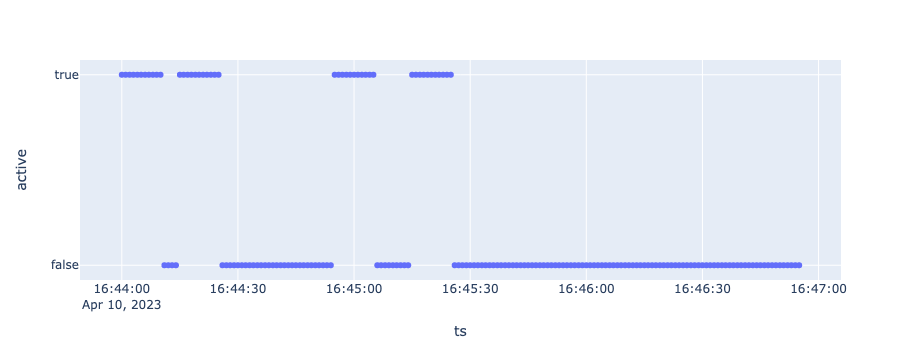

time: 322 ms (started: 2023-04-27 01:28:23 -04:00)


In [15]:
import duckdb

ts = pd.date_range(qdf.era_start.min(), qdf.era_end.max() + pd.Timedelta(minutes=1.5), freq='1S')
df_time = pd.DataFrame(ts, columns=['ts'])
df_time

df = duckdb.query("""
with timeseries as (
    select * from df_time
)
select
    ts,
    count(era_start) > 0 as active
from 
    timeseries t
left join qdf 
on t.ts between qdf.era_start and qdf.era_end
group by 1
order by ts
""").df()

df

import plotly.express as px
fig = px.scatter(
    df,
    x='ts',
    y='active'
)
fig.update_yaxes(autorange="reversed")

fig.show()

In [19]:


# state = list(zip(df.timestamp, df.eras_found))

# def wh_events_simulated(wh_activity_series):

state = list(zip(df.ts, df.active))
started = False
events = []

def maybe_suspend(started, active, time_since_resumed):
    # smart shutdown
    return started and (not active) and (time_since_resumed >= Timedelta(seconds=60))

for (ts, active) in state:
    # print(f"{ts}, {active}")
    if active and not started:
        started = True
        resumed_on = ts
        events.append((ts, 'resume'))

    if maybe_suspend(started, active, ts - resumed_on):
        started = False
        events.append((ts, 'suspend'))

test_events_df = pd.DataFrame(events, columns=['timestamp', 'event_type'])
test_events_df

,timestamp,event_type
0,2023-04-10 16:44:00,resume
1,2023-04-10 16:45:06,suspend
2,2023-04-10 16:45:15,resume
3,2023-04-10 16:46:15,suspend


time: 21.4 ms (started: 2023-04-27 01:40:06 -04:00)


In [20]:
expected_events = [
 {'timestamp': Timestamp('2023-04-10 16:44:00'), 'event_type': 'resume'},
 {'timestamp': Timestamp('2023-04-10 16:45:06'), 'event_type': 'suspend'},
 {'timestamp': Timestamp('2023-04-10 16:45:15'), 'event_type': 'resume'},
 {'timestamp': Timestamp('2023-04-10 16:46:15'), 'event_type': 'suspend'}
]

expected_df = pd.DataFrame.from_dict(expected_events)

pd.testing.assert_frame_equal(test_events_df, expected_df)
pd.testing.assert_frame_equal(fast_simulation_df, expected_df)

time: 7.1 ms (started: 2023-04-27 01:40:34 -04:00)


In [23]:
df = sql_to_df("show warehouses")
df

07:23:39 INFO:query: [show warehouses]
07:23:39 INFO:query execution done


,name,state,type,size,running,queued,is_default,is_current,auto_suspend,auto_resume,...,resumed_on,updated_on,owner,comment,resource_monitor,actives,pendings,failed,suspended,uuid
0,AUTOSUSPEND_SIXTY,SUSPENDED,STANDARD,X-Small,0,0,N,N,60,true,...,2023-04-11 15:13:28.746000+00:00,2023-04-11 15:13:28.746000+00:00,SNOWFLAKE_USAGE,,null,0,0,0,1,52231856
1,DEMO,SUSPENDED,STANDARD,X-Small,0,0,N,N,37,true,...,2023-04-24 22:41:33.199000+00:00,2023-04-24 22:41:33.200000+00:00,SNOWFLAKE_USAGE,,null,0,0,0,1,52231684
2,DEMO_SMALL,SUSPENDED,STANDARD,Small,0,0,N,N,60,true,...,2023-04-14 19:51:59.018000+00:00,2023-04-14 19:51:59.018000+00:00,ACCOUNTADMIN,,null,0,0,0,2,52231688
3,OPS,SUSPENDED,STANDARD,X-Small,0,0,N,Y,60,true,...,2023-04-24 01:25:27.291000+00:00,2023-04-24 01:25:27.291000+00:00,ACCOUNTADMIN,,null,0,0,0,1,52231696
4,SMARTSUSPEND_TEN,SUSPENDED,STANDARD,X-Small,0,0,N,N,60,true,...,2023-04-11 15:13:28.918000+00:00,2023-04-11 15:13:28.918000+00:00,SNOWFLAKE_USAGE,,null,0,0,0,1,52231860
5,SUSPEND_TEN,SUSPENDED,STANDARD,X-Small,0,0,N,N,60,true,...,2023-04-11 18:35:58.296000+00:00,2023-04-11 18:35:58.296000+00:00,SNOWFLAKE_USAGE,,null,0,0,0,1,52231864
6,TEST_WH_123,SUSPENDED,STANDARD,X-Small,0,0,N,N,60,true,...,2023-04-24 22:42:38.597000+00:00,2023-04-24 22:42:38.597000+00:00,DEV,,null,0,0,0,1,52231872


time: 214 ms (started: 2023-04-24 19:23:39 -04:00)


In [9]:
managed = {
       "account": [
            'DEMO'
       ]
}

def maybe_suspend_warehouses(whs):
    logger.info("======== processing warehouses ===============================================================================================\n")
    df = sql_to_df("show warehouses")
    states = df.set_index('name', drop=False).to_dict('index')
    
    for wh in whs:
        logger.info(f"======== processing warehouse {wh} ===============================================================================================\n")
        status = states[wh]
        started = status['state'] == 'STARTED'
        resumed_on = status['resumed_on']
        time_since_resumed = pd.Timestamp.utcnow() - resumed_on
        active = (status['running'] + status['queued']) > 0
        
        logger.info(f"started {started} | active {active} | time_since_resumed {time_since_resumed}")

        suspend = maybe_suspend(started, active, time_since_resumed) 
        if suspend:
            wh = status['name']
            logger.info(f"SUSPENDING WAREHOUSE {wh}")
            # run_sql(f"ALTER WAREHOUSE {wh} SUSPEND")



time: 1.33 ms (started: 2023-04-25 01:29:08 -04:00)


In [21]:
import threading

print("Number of active threads:", threading.active_count())

Number of active threads: 10
time: 7.28 ms (started: 2023-04-27 02:02:20 -04:00)


In [10]:
while True:
    time.sleep(1)
    maybe_suspend_warehouses(managed)

01:29:10 INFO:======== processing warehouses ===============================================================================================

01:29:10 INFO:query: [show warehouses]
01:29:11 INFO:query execution done
01:29:11 INFO:======== processing warehouse DEMO ===============================================================================================

01:29:11 INFO:started False | active False | time_since_resumed 0 days 06:47:38.520017
01:29:12 INFO:======== processing warehouses ===============================================================================================

01:29:12 INFO:query: [show warehouses]
01:29:12 INFO:query execution done
01:29:12 INFO:======== processing warehouse DEMO ===============================================================================================

01:29:12 INFO:started False | active False | time_since_resumed 0 days 06:47:39.679108
01:29:13 INFO:======== processing warehouses =========================================================

KeyboardInterrupt: 

time: 2min 21s (started: 2023-04-25 01:29:09 -04:00)


In [ ]:
import duckdb
duckdb.query("select * from wh_df")

CatalogException: Catalog Error: Table with name wh_df does not exist!
Did you mean "pg_am"?

time: 116 ms (started: 2023-04-24 11:17:43 -04:00)


In [ ]:
duckdb.query("""
select  * from
generate_series(
        (select min(era_start) from wh_df),
        (select max(era_end) from wh_df),
        interval 1 second
    );
""")

BinderException: Binder Error: Table function can have at most one subquery parameter 

time: 14.8 ms (started: 2023-04-20 21:39:43 -04:00)


In [ ]:
duckdb.query("""
SELECT 
* 
FROM 
generate_series(
    (select min(era_start) from wh_df)::timestamp,
    TIMESTAMP '2021-11-29', 
    INTERVAL 1 DAY
);

""")

BinderException: Binder Error: Table function cannot contain subqueries

time: 16.5 ms (started: 2023-04-20 21:42:35 -04:00)


In [ ]:
duckdb.query("""
SELECT * FROM generate_series(TIMESTAMP '2021-01-01', TIMESTAMP '2021-11-29', INTERVAL 1 DAY);

""")

┌─────────────────────┐
│   generate_series   │
│      timestamp      │
├─────────────────────┤
│ 2021-01-01 00:00:00 │
│ 2021-01-02 00:00:00 │
│ 2021-01-03 00:00:00 │
│ 2021-01-04 00:00:00 │
│ 2021-01-05 00:00:00 │
│ 2021-01-06 00:00:00 │
│ 2021-01-07 00:00:00 │
│ 2021-01-08 00:00:00 │
│ 2021-01-09 00:00:00 │
│ 2021-01-10 00:00:00 │
│          ·          │
│          ·          │
│          ·          │
│ 2021-11-20 00:00:00 │
│ 2021-11-21 00:00:00 │
│ 2021-11-22 00:00:00 │
│ 2021-11-23 00:00:00 │
│ 2021-11-24 00:00:00 │
│ 2021-11-25 00:00:00 │
│ 2021-11-26 00:00:00 │
│ 2021-11-27 00:00:00 │
│ 2021-11-28 00:00:00 │
│ 2021-11-29 00:00:00 │
├─────────────────────┤
│ 333 rows (20 shown) │
└─────────────────────┘

time: 6.55 ms (started: 2023-04-20 21:40:05 -04:00)
